# EXPLAIN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
root_df = pd.read_csv('../input/ads.csv', parse_dates=['first_seen'])
df = root_df.copy()

df = df.drop(df[df.site == 'parius'].index)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 0 to 2202
Data columns (total 8 columns):
street        1606 non-null object
city          1606 non-null object
size          1536 non-null float64
price         1606 non-null float64
first_seen    1606 non-null datetime64[ns]
site          1606 non-null object
type          1506 non-null object
open          1606 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(2), object(4)
memory usage: 101.9+ KB


### FIND MISSING / FILLNA

In [4]:
for col in df.columns:
    print(f'{col} - {df[col].isnull().any()} - pct missing: {(df[col].isnull().sum(axis=0) / len(df)) * 100}')

street - False - pct missing: 0.0
city - False - pct missing: 0.0
size - True - pct missing: 4.35865504358655
price - False - pct missing: 0.0
first_seen - False - pct missing: 0.0
site - False - pct missing: 0.0
type - True - pct missing: 6.226650062266501
open - False - pct missing: 0.0


In [5]:
df.fillna(df.median(), inplace=True)

### Dummy encode cities

In [6]:
df['city_old'] = df['city']
df = pd.get_dummies(
    df, columns=['city'], 
    prefix=['city']
)

## Do de shizzle met type

- Kamer
- studio
- Appartement
- benedenwoning
- bovenwoning
- Huis


In [7]:
def type_detector(x):
    try:
        if 'kamer' in x.lower():
            return 'kamer'

        elif 'studio' in x.lower():
            return 'studio'

        elif 'appartement' in x.lower():
            return 'appartement'
        
        elif 'benedenwoning' in x.lower():
            return 'benedenwoning'
        
        elif 'bovenwoning' in x.lower():
            return 'bovenwoning'

        elif 'huis' in x.lower():
            return 'huis'
        
        else:
            return 'other'
    
    except:
        pass

In [8]:
df['house_type'] = df['type'].apply(type_detector)

In [9]:
df['type'] = df['house_type']
df = pd.get_dummies(
    df, columns=['house_type'], 
)

## Duplicate situation

### Convert datetime to Y/M/D --> want voor duplicates (latere dagen kunnen ieuwe intries in zelfde gebouw zijn)

In [10]:
df['first_seen'] = df['first_seen'].dt.date

In [11]:
df.columns

Index(['street', 'size', 'price', 'first_seen', 'site', 'type', 'open',
       'city_old', 'city_amsterdam', 'city_haarlem', 'city_hilversum',
       'city_utrecht', 'house_type_appartement', 'house_type_benedenwoning',
       'house_type_bovenwoning', 'house_type_huis', 'house_type_kamer',
       'house_type_other', 'house_type_studio'],
      dtype='object')

#### Some duplicates

In [12]:
df.duplicated(list(df.drop(['site', 'open', 'city_old', 'type'], axis=1)), keep=False).value_counts()

False    1428
True      178
dtype: int64

# Prijs van NIEUWE advertenties, per stad, gegroepeerd per type en site - met een voortschrijdend gemiddelde van 7 dagen

## AMSTERDAM

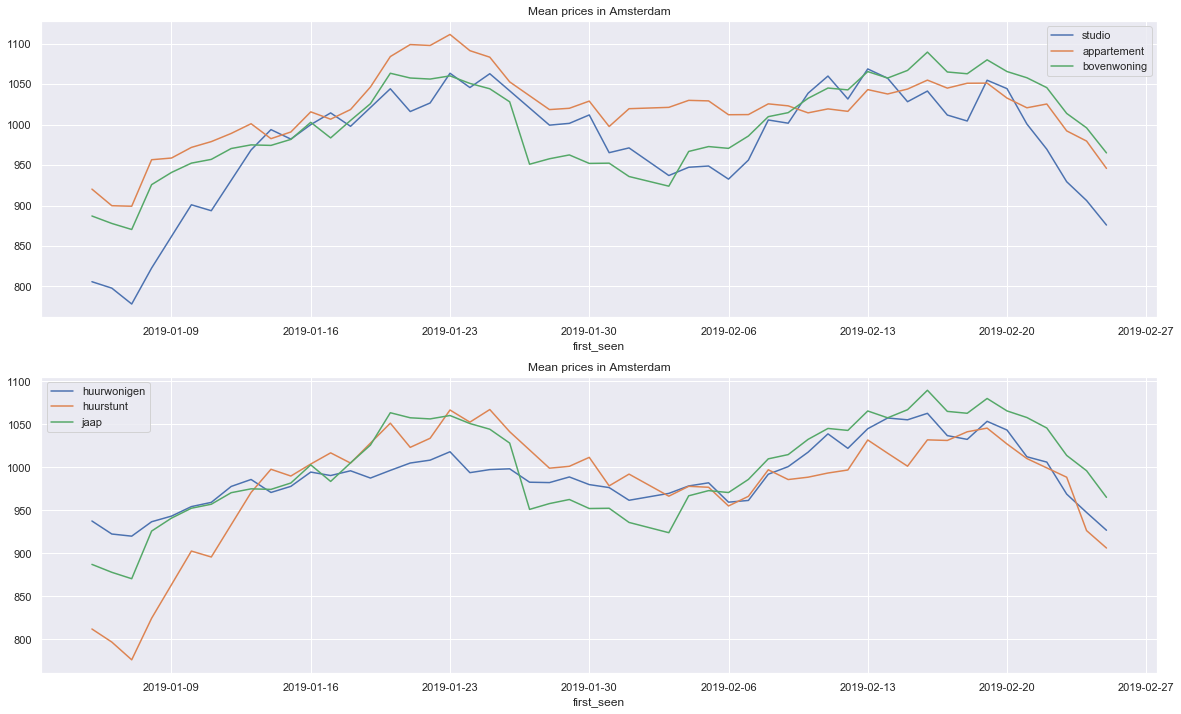

In [54]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(20, 12))

df[
    (df['city_amsterdam'] == 1) | (df['type'] == 'studio')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='studio', ax=axes[0], title='Mean prices in Amsterdam')
df[
    (df['city_amsterdam'] == 1) | (df['type'] == 'appartement')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='appartement', ax=axes[0])
df[
    (df['city_amsterdam'] == 1) | (df['site'] == 'jaap') | (df['type'] == 'bovenwoning')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='bovenwoning', ax=axes[0])
axes[0].legend()

df[
    (df['city_amsterdam'] == 1) | (df['site'] == 'huurwoningen')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='huurwonigen', ax=axes[1], title='Mean prices in Amsterdam')
df[
    (df['city_amsterdam'] == 1) | (df['site'] == 'huurstunt')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='huurstunt', ax=axes[1])
df[
    (df['city_amsterdam'] == 1) | (df['site'] == 'jaap')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='jaap', ax=axes[1])
axes[1].legend()

## Haarlem

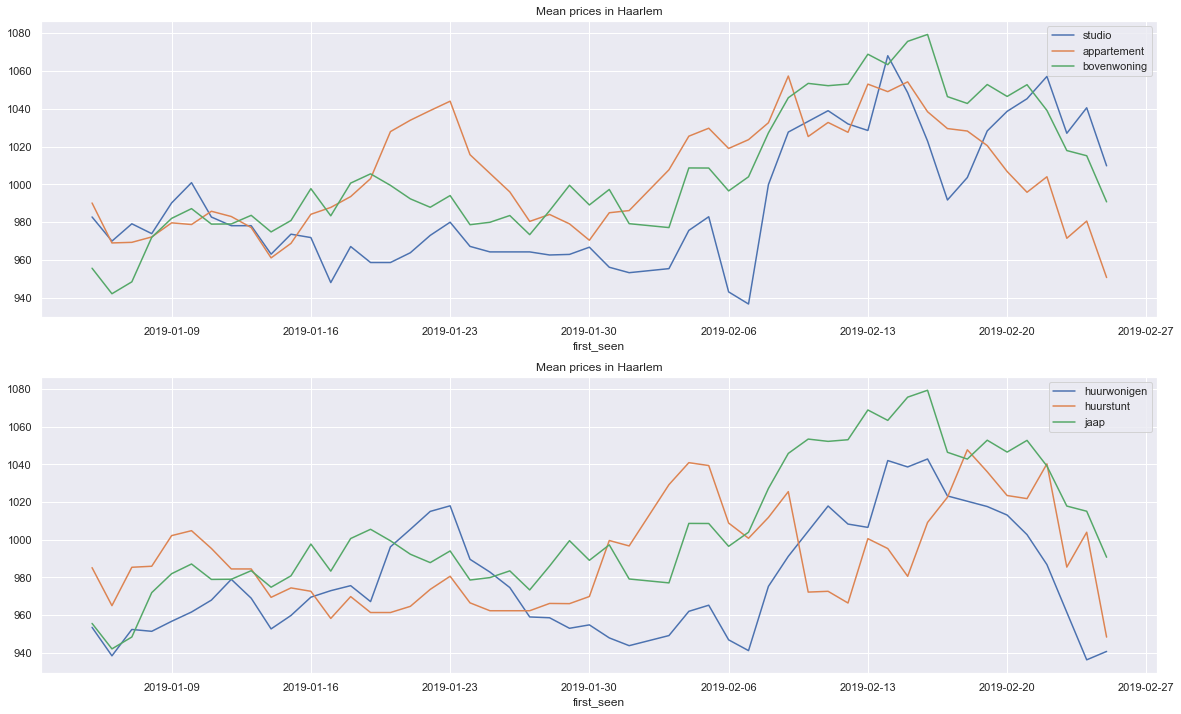

In [14]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(20, 12))

df[
    (df['city_haarlem'] == 1) | (df['type'] == 'studio')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='studio', ax=axes[0], title='Mean prices in Haarlem')
df[
    (df['city_haarlem'] == 1) | (df['type'] == 'appartement')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='appartement', ax=axes[0])
df[
    (df['city_haarlem'] == 1) | (df['site'] == 'jaap') | (df['type'] == 'bovenwoning')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='bovenwoning', ax=axes[0])
axes[0].legend()

df[
    (df['city_haarlem'] == 1) | (df['site'] == 'huurwoningen')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='huurwonigen', ax=axes[1], title='Mean prices in Haarlem')
df[
    (df['city_haarlem'] == 1) | (df['site'] == 'huurstunt')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='huurstunt', ax=axes[1])
df[
    (df['city_haarlem'] == 1) | (df['site'] == 'jaap')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='jaap', ax=axes[1])
axes[1].legend()

## Utrecht

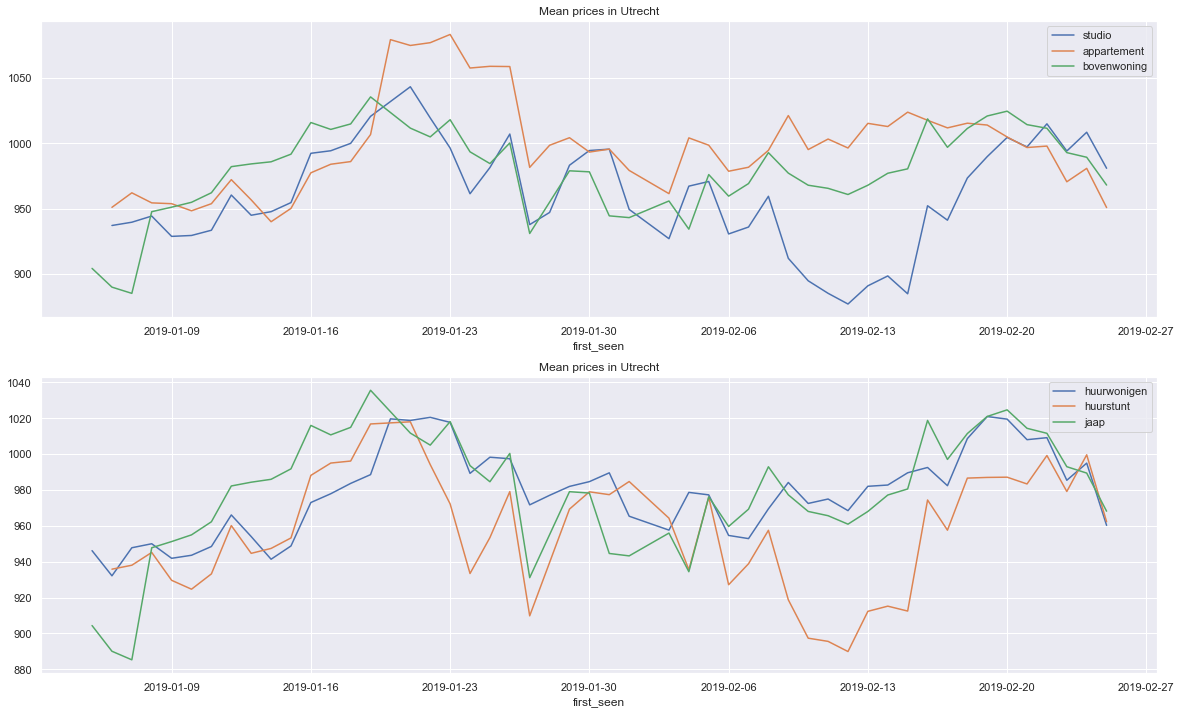

In [15]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(20, 12))

df[
    (df['city_utrecht'] == 1) | (df['type'] == 'studio')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='studio', ax=axes[0], title='Mean prices in Utrecht')
df[
    (df['city_utrecht'] == 1) | (df['type'] == 'appartement')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='appartement', ax=axes[0])
df[
    (df['city_utrecht'] == 1) | (df['site'] == 'jaap') | (df['type'] == 'bovenwoning')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='bovenwoning', ax=axes[0])
axes[0].legend()

df[
    (df['city_utrecht'] == 1) | (df['site'] == 'huurwoningen')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='huurwonigen', ax=axes[1], title='Mean prices in Utrecht')
df[
    (df['city_utrecht'] == 1) | (df['site'] == 'huurstunt')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='huurstunt', ax=axes[1])
df[
    (df['city_utrecht'] == 1) | (df['site'] == 'jaap')
].groupby('first_seen').mean()['price'].rolling(7).mean().plot(label='jaap', ax=axes[1])
axes[1].legend()

# Type, aantal en prijs van advertenties, per stad.

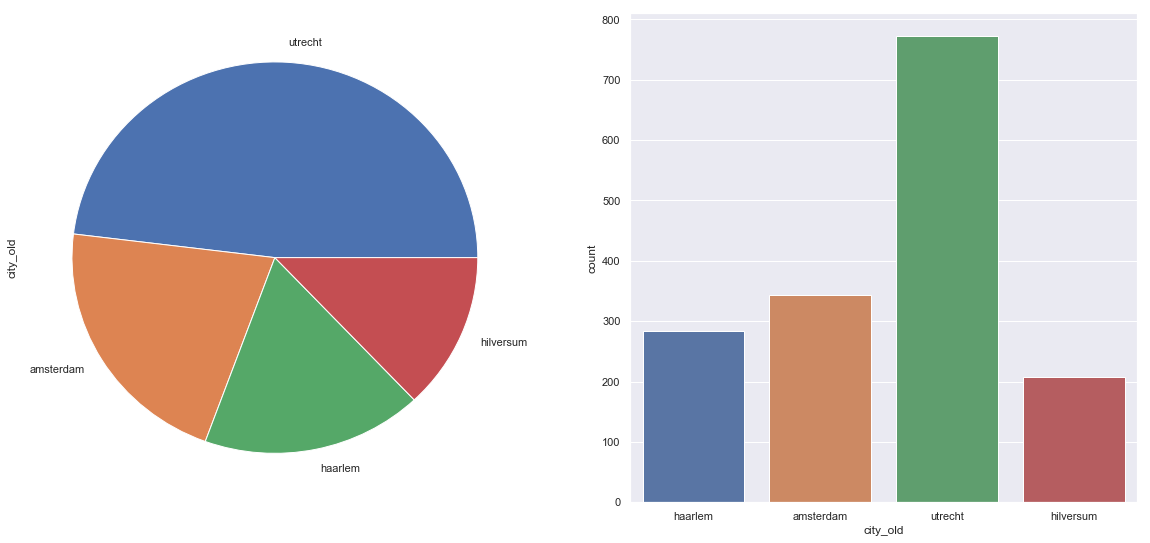

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 9))
df['city_old'].value_counts().plot.pie(ax=axes[0])
sns.countplot('city_old', data=df, ax=axes[1])

## Aantal , per type

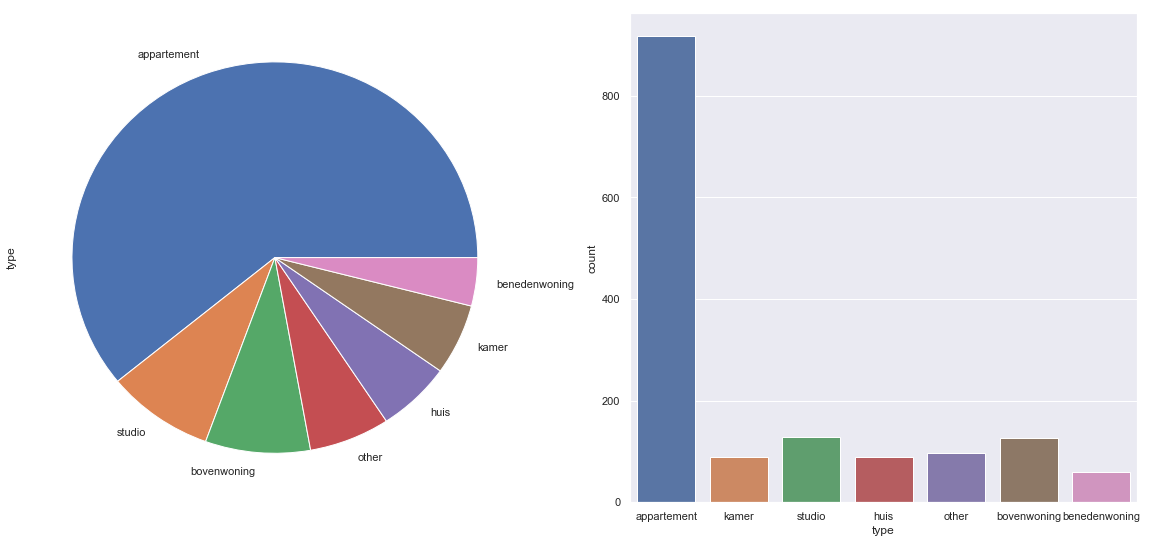

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 9))
df['type'].value_counts().plot.pie(ax=axes[0])
sns.countplot('type', data=df, ax=axes[1])

## Aantal, per type, per stad

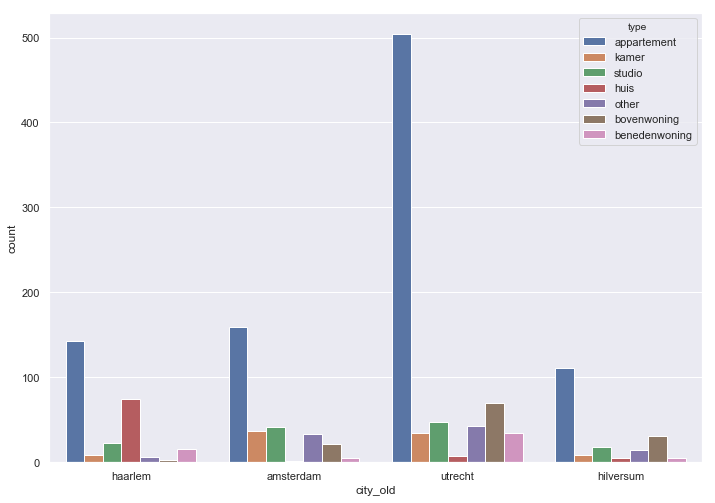

In [18]:
sns.countplot('city_old', hue=df['type'], data=df)

# Prijs / Oppervlakte per type / stad

In [55]:
df.groupby('type')['size'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
appartement,917.0,57.291167,48.102184,0.0,39.0,50.0,70.0,1000.0
benedenwoning,60.0,51.733333,23.634840,0.0,40.0,51.0,65.0,150.0
bovenwoning,126.0,54.317460,20.869749,4.0,35.5,53.5,70.0,110.0
huis,89.0,58.988764,24.930583,0.0,50.0,50.0,50.0,197.0
kamer,88.0,21.125000,16.288218,5.0,14.0,18.0,22.0,118.0
other,97.0,78.010309,42.076442,0.0,40.0,80.0,107.0,248.0
studio,129.0,33.682171,22.218019,0.0,25.0,30.0,39.0,145.0


In [19]:
df.groupby('type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
appartement,917.0,1019.573610,192.722378,0.0,900.00,1050.0,1175.00,1250.0
benedenwoning,60.0,1031.800000,171.848948,596.0,949.75,1050.0,1156.25,1250.0
bovenwoning,126.0,1005.515873,177.727690,500.0,890.00,997.5,1150.00,1250.0
huis,89.0,966.337079,102.616446,835.0,905.00,940.0,940.00,1250.0
kamer,88.0,614.352273,160.761553,400.0,500.00,555.0,666.25,1000.0
other,97.0,993.288660,220.975723,400.0,900.00,1025.0,1175.00,1250.0
studio,129.0,884.333333,209.581366,430.0,725.00,895.0,1050.00,1250.0


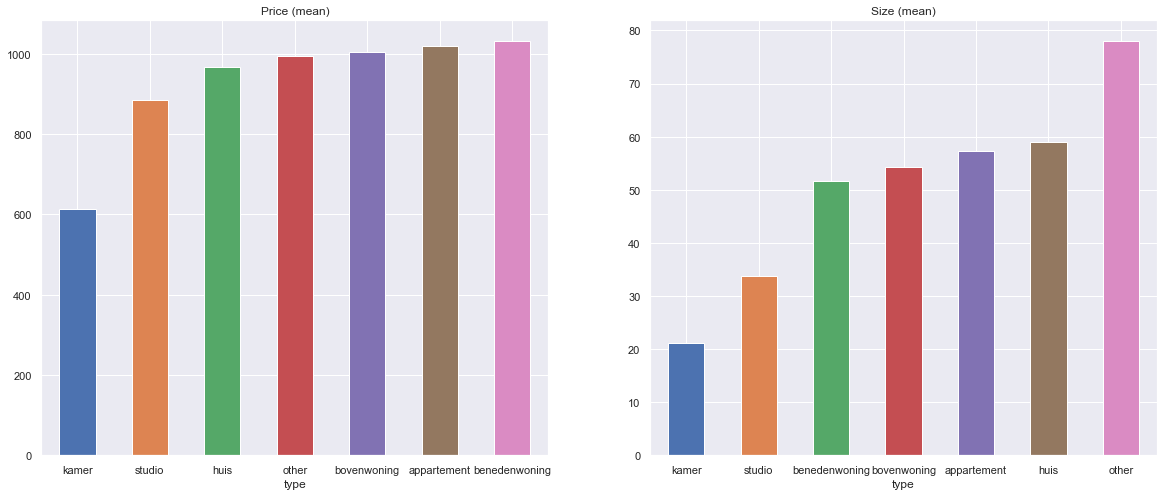

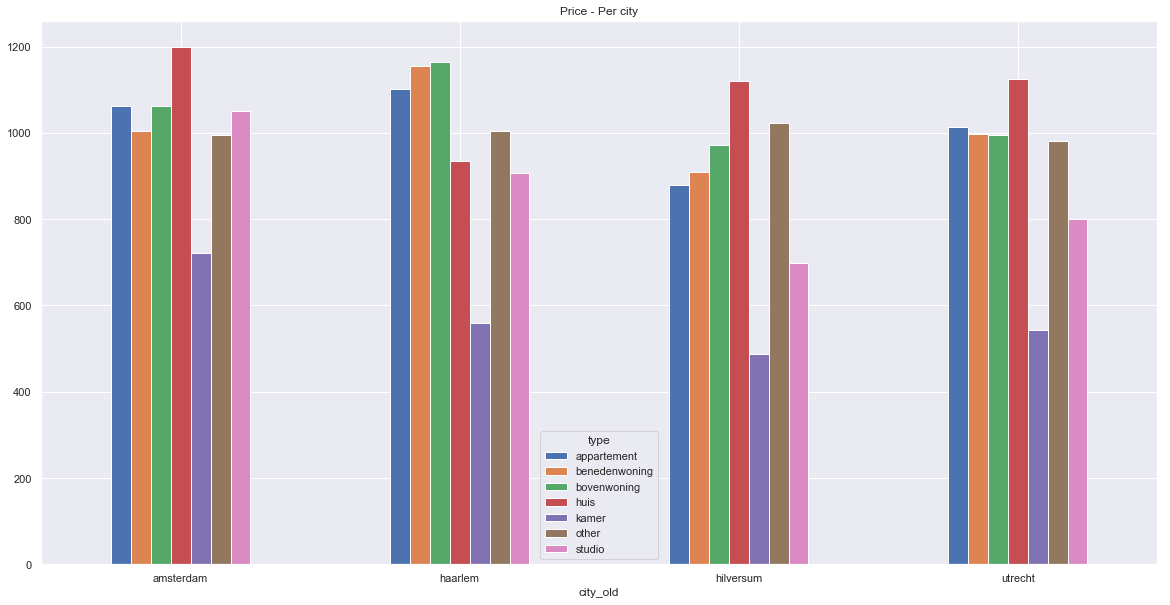

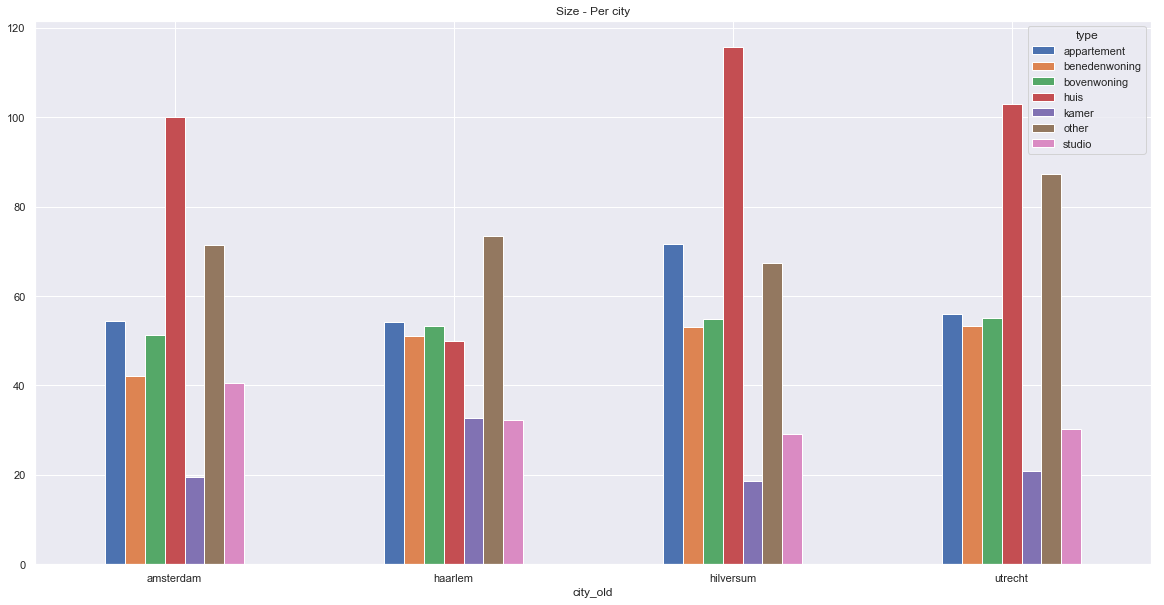

In [59]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
df.groupby('type')['price'].mean().sort_values(ascending=True).plot.bar(rot=0, ax=axes[0], title='Price (mean)')
df.groupby('type')['size'].mean().sort_values(ascending=True).plot.bar(rot=0, ax=axes[1], title='Size (mean)')
df.groupby(['city_old', 'type'])['price'].mean().unstack().plot.bar(rot=0, figsize=(20,10), title='Price - Per city')
df.groupby(['city_old', 'type'])['size'].mean().unstack().plot.bar(rot=0, figsize=(20,10), title='Size - Per city')

# Prijs en oppervlakte van advertenties

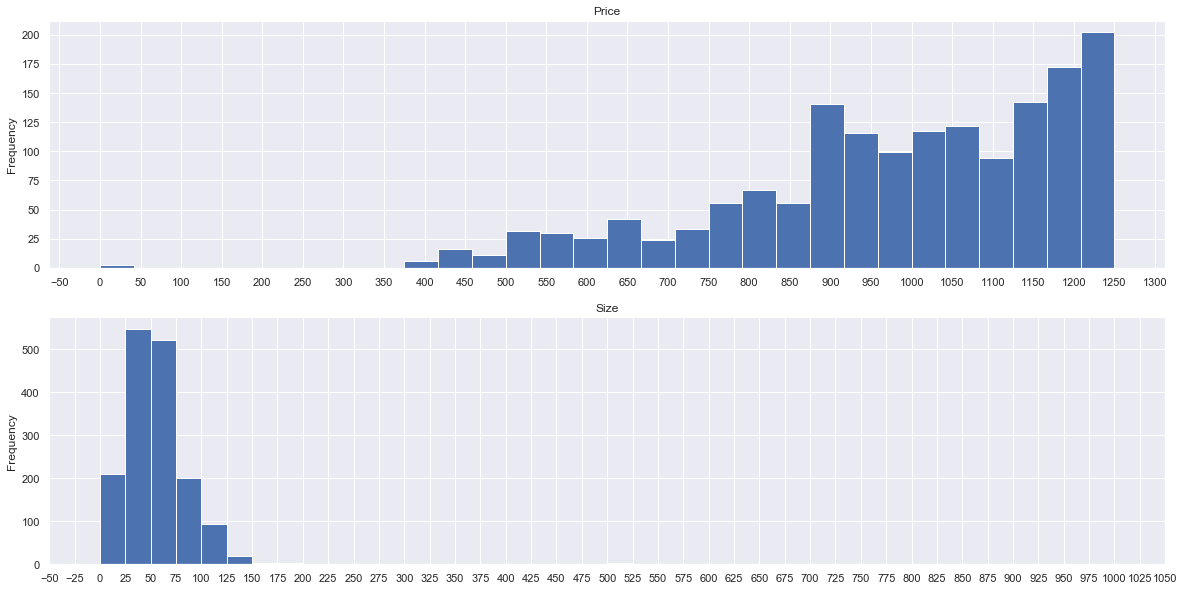

In [49]:
import matplotlib.ticker as plticker
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
loc = plticker.MultipleLocator(base=50.0)
df['price'].plot.hist(ax=axes[0], bins=30, title='Price').xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=25.0)
df['size'].plot.hist(ax=axes[1], bins=40, title='Size').xaxis.set_major_locator(loc)

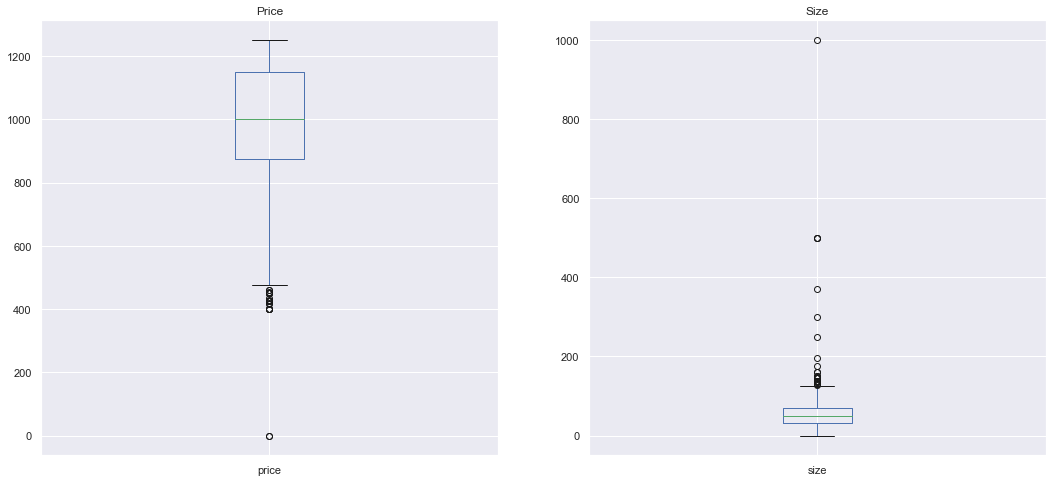

In [51]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 8))
df['price'].plot.box(ax=axes[0], title='Price')
df['size'].plot.box(ax=axes[1], title='Size')

# Relatie prijs / oppervlak

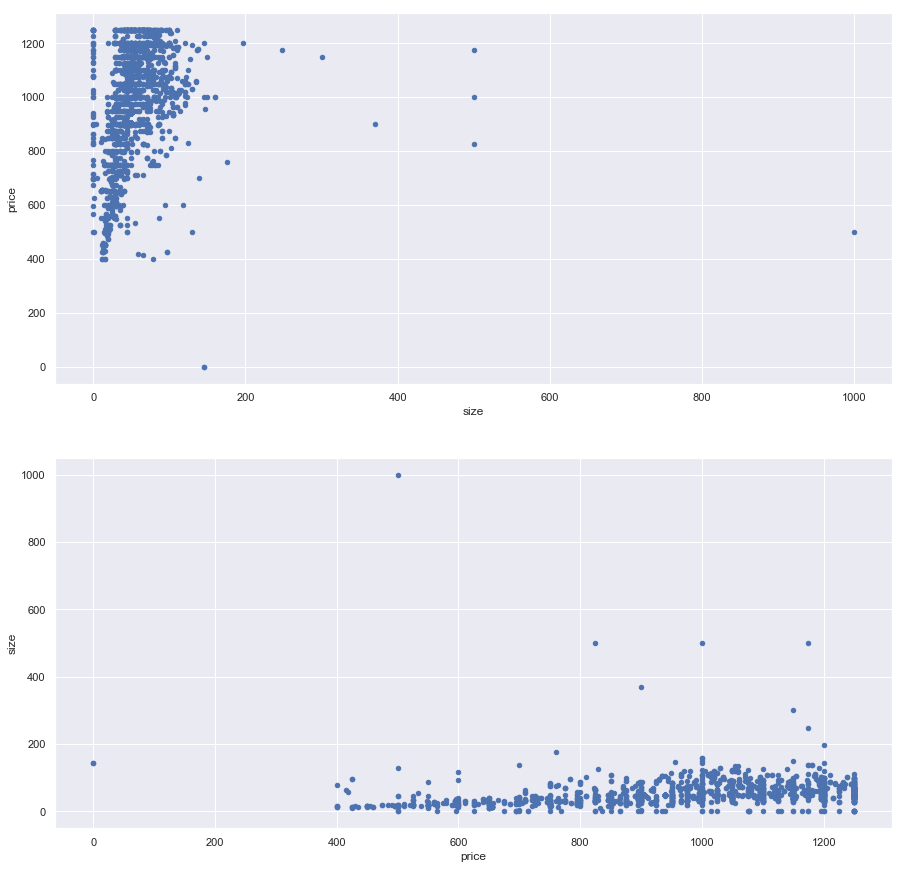

In [23]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15,15))
df.plot.scatter('size', 'price', ax=axes[0])
df.plot.scatter('price', 'size', ax=axes[1])

## Zonder outliers

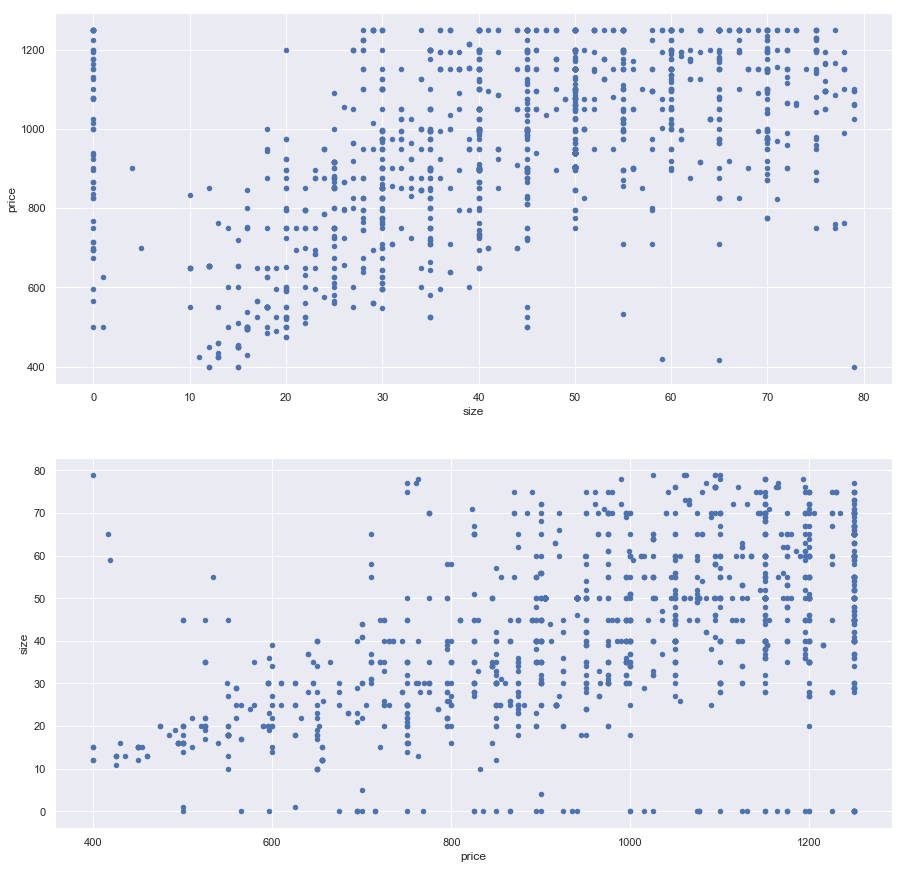

In [24]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15,15))
df[df['size'] < 80].plot.scatter('size', 'price', ax=axes[0])
df[df['size'] < 80].plot.scatter('price', 'size', ax=axes[1])

### Corrolatie (pearons r / met prijs) matrix

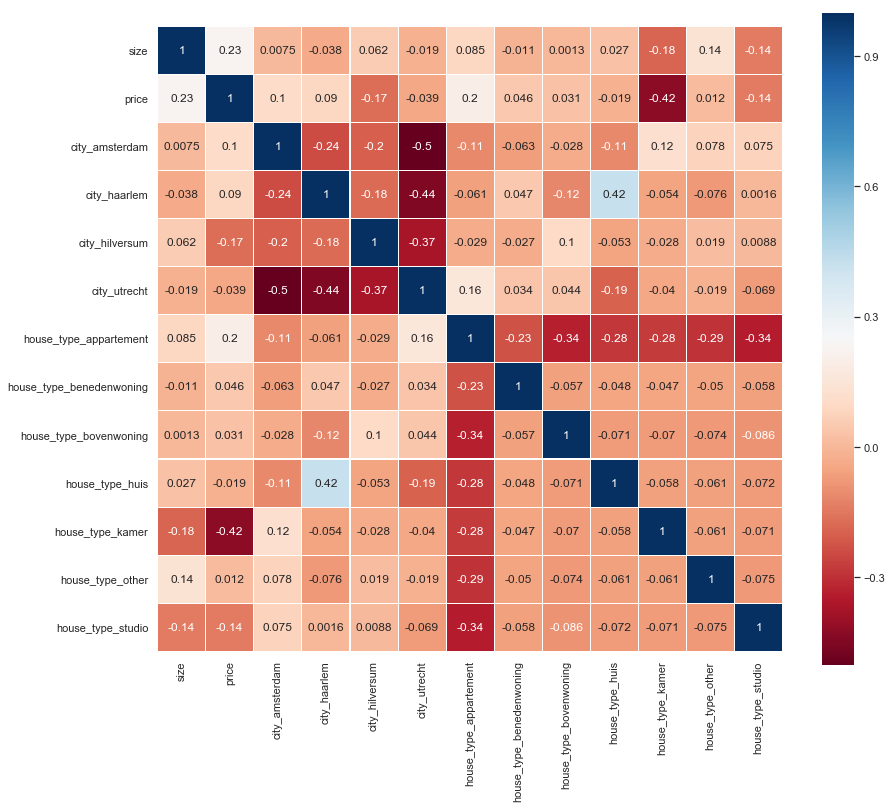

In [25]:
plt.figure(figsize=(14,12))
sns.heatmap(df[
    list(df.drop(['open'], axis=1))
].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

## Corrolatie (oearons r / met prijs), sterkte en richting

(array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3]),
 <a list of 9 Text xticklabel objects>)

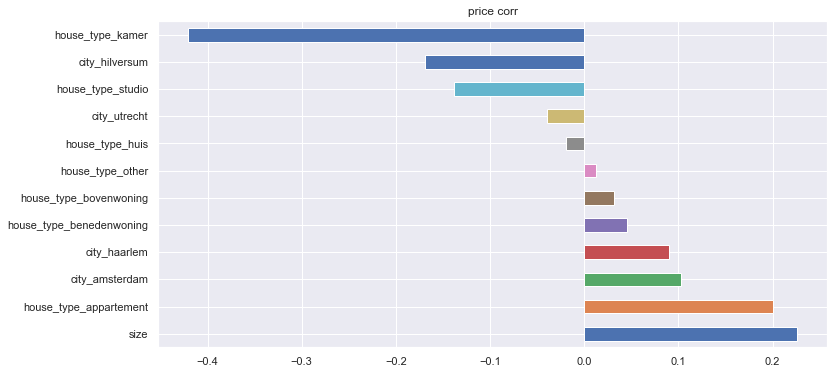

In [26]:
df.corr()['price'].drop(['price', 'open']).sort_values(ascending=False).plot.barh(figsize=(12,6), title='price corr')
plt.xticks(rotation=0)

# Regressie (OLS) tabel, met prijs als dependent variable

### Steden zijn dummy encoded, Utrecht word als baseline weggelaten
### 'Other' als type als basis weggelaten

In [27]:
df['city_old'].value_counts()

utrecht      772
amsterdam    343
haarlem      283
hilversum    208
Name: city_old, dtype: int64

In [28]:
cols = [
    'size', 'city_amsterdam', 'city_haarlem', 'city_utrecht', 
    'house_type_appartement', 'house_type_benedenwoning', 'house_type_bovenwoning',
    'house_type_huis', 'house_type_kamer', 'house_type_studio'
]
model = sm.OLS(df['price'], sm.add_constant(df[cols])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     64.91
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          6.64e-111
Time:                        17:39:11   Log-Likelihood:                -10599.
No. Observations:                1606   AIC:                         2.122e+04
Df Residuals:                    1595   BIC:                         2.128e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

# Change=   |  OLS REGRESSION

Patroon herhaalt zich, change= is als studio relatief goedkoop

In [29]:
def predictor(size, type='studio', city='amsterdam', model=None, intercept=True):
    if not model:
        raise ValueError('Model not set!')
    size_slope = model.params['size']
    if city:
        city_slope = model.params['city_' + city.lower()]
    else: 
        city_slope = 0
    type_slope = model.params['house_type_' + type.lower()]
    if intercept:
        intercept = model.params['const']
    else: 
        intercept = 0

    price = intercept + (size * size_slope) + city_slope + type_slope
    return price


#### Schatting OLS voor Studio van 30m2 in Amsterdam

In [30]:
predictor(30, type='studio', model=model, city='Amsterdam')

938.5834584054988

# CHANGE SKLEARN MODEL

In [56]:
change = { 
    'size': [30], 'city_amsterdam': [1], 'city_haarlem': [0], 'city_hilversum': [0],
    'city_utrecht': [0], 'house_type_appartement': [0], 'house_type_benedenwoning': [0],
    'house_type_bovenwoning': [0], 'house_type_huis': [0], 'house_type_kamer': [0],
    'house_type_other':[0] , 'house_type_studio': [1]
}
change_df = pd.DataFrame.from_dict(change)

## Linear

In [31]:
sk_df = df.drop(['street', 'type', 'first_seen', 'site', 'open', 'city_old'], axis=1)
X = sk_df.drop('price', axis=1)
y = sk_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
reg = GridSearchCV(LinearRegression(), cv=10, param_grid={'fit_intercept': [True, False]})
reg.fit(X_train, y_train)

reg.score(X_test, y_test)

0.3198171423592542

In [33]:
X.columns

Index(['size', 'city_amsterdam', 'city_haarlem', 'city_hilversum',
       'city_utrecht', 'house_type_appartement', 'house_type_benedenwoning',
       'house_type_bovenwoning', 'house_type_huis', 'house_type_kamer',
       'house_type_other', 'house_type_studio'],
      dtype='object')

## Predictie Linear model

In [36]:
reg.predict(change_df)


array([925.985199])

## GradientBoostingRegressor (XGB)

In [40]:
def print_report(model, best_params=True):
    if best_params:
        print('BEST PARAMS:\n')
        print(
            'Model: '+ str(model.best_params_)
        )
    print('\n\nACCURACY SCORES:\n')
    print(
        'R2: ' + str(r2_score(y_test, model.predict(X_test)))
    )
    print(
        'MSE: ' + str(mean_squared_error(y_test, model.predict(X_test)))
    )
    try:
        print(
            'MSE_LOG: ' + str(mean_squared_log_error(y_test, model.predict(X_test)))
        ) 
    except:
        print('MSE_LOG: ERROR')
    

In [41]:
%%time
%%capture [--no-stdout]

pipe = Pipeline(steps=[
    ('feature', None),
    ('pre', None),
    ('poly', PolynomialFeatures(2)),
    ('pca', None),
    ('reg', XGBRegressor()),
    ]
)

params = { 
    'pre': [
        None, StandardScaler(), MinMaxScaler(),
    ],
    'pca': [None, PCA(n_components=0.95), PCA(n_components=0.75)],
    'poly__degree': [1,2, 3],
#     'reg__alpha': [0.5, 1, 10],
}


reg_clf = GridSearchCV(
    pipe, param_grid=params, cv=10, n_jobs=-1, scoring='mean_squared_error'
)

reg_clf.fit(X_train, y_train)

CPU times: user 1.12 s, sys: 52 ms, total: 1.18 s
Wall time: 50.3 s


In [42]:
print_report(reg_clf)

BEST PARAMS:

Model: {'pca': None, 'poly__degree': 2, 'pre': MinMaxScaler(copy=True, feature_range=(0, 1))}


ACCURACY SCORES:

R2: 0.563301764767972
MSE: 21320.67970898825
MSE_LOG: 0.10373528095258662


## Predictie XGB model

In [43]:
reg_clf.predict(change_df)

array([1080.6403], dtype=float32)